<a href="https://colab.research.google.com/github/AndreaCattaneo19/Progetto-DSIM/blob/main/LSTM%26GRU_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Librerie

In [ ]:
from tensorflow import random
random.set_seed(123)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px

from sklearn.metrics import mean_absolute_percentage_error as mape

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import GRU

#Modello LSTM (Long Short Term Memory)

### Import e preparazione dei dati


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/PROGETTO_SDMTS_CONSEGNA/Codice_parte_ML/No_null_project_data.csv')


In [ ]:
df.head()

,Date,Hour,CO,Time
0,2004-03-10,18,1360,2004-03-10 18:00:00
1,2004-03-10,19,1292,2004-03-10 19:00:00
2,2004-03-10,20,1402,2004-03-10 20:00:00
3,2004-03-10,21,1376,2004-03-10 21:00:00
4,2004-03-10,22,1272,2004-03-10 22:00:00


In [ ]:
#df.dtypes

In [ ]:
#Ricostruisco variabile Time perchè non sembra possibile evitare che pd.to_datetime inserisca il salto del cambio d'ora
df['Time'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], 'h')

In [ ]:
#Cancello colonne non più necessarie
df.drop(['Date', 'Hour'], axis='columns', inplace=True)

In [ ]:
df.dtypes

CO               int64
Time    datetime64[ns]
dtype: object

In [ ]:
#df.head()

In [ ]:
#Controllo la presenza di nulli
df.isnull().sum()

CO      0
Time    0
dtype: int64

In [ ]:
#Setto la data come indice
df.set_index('Time', inplace=True)


In [ ]:
df.head()

,CO
Time,
2004-03-10 18:00:00,1360
2004-03-10 19:00:00,1292
2004-03-10 20:00:00,1402
2004-03-10 21:00:00,1376
2004-03-10 22:00:00,1272


In [ ]:
#Il dataset viene convertito in una struttura più adatta ad essere gestita da una rete neurale: un numpy array di tipo float
data=df
data=data.values
data=data.astype('float32')
data

array([[1360.],
       [1292.],
       [1402.],
       ...,
       [ 827.],
       [ 776.],
       [ 755.]], dtype=float32)

In [ ]:
type(data)

numpy.ndarray

In [ ]:
#Poiché i modelli LSTM sono sensibili alla scala dell'input i dati vengono normalizzati
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

#si creano train e test set (stesso split 80-20 usato per Arima e UCM)
train, test = dataset[0:6821,:], dataset[6821:len(dataset), :]

In [ ]:
print(train)

[[0.511845  ]
 [0.4630294 ]
 [0.54199576]
 ...
 [0.50681984]
 [0.43575016]
 [0.3890883 ]]


In [ ]:
print(test)

[[0.38478103]
 [0.3862168 ]
 [0.32376167]
 ...
 [0.12921754]
 [0.09260592]
 [0.07753053]]


A questo punto è necessario strutturare i dati in una forma che divida le osservazioni di training set e test set in X e Y. Dove con X si indicano i valori da utilizzare per prevere il valore successivo Y.
Questa struttura è espressamente richiesta dalla rete. La quantità di osservazioni necessarie a prevedere la successiva sarà definita dal parametro lookback.
In questo caso data la presenza di una stagionalità giornaliera e settimanale sui dati orari si è scelto di settare lookback a 168=24*7 (che comprende anche la stagionalità giornaliera)


In [ ]:
def X_Y_split(dataset, look_back):
  X, Y = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    X.append(a)
    Y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(Y)

In [ ]:
look_back=168

In [ ]:
TrainX, TrainY = X_Y_split(train, look_back)

In [ ]:
#Composto di n vettori, ciascuno dei quali contiene 168 osservazioni con cui prevedere la relativa Y
TrainX

array([[0.511845  , 0.4630294 , 0.54199576, ..., 0.40201005, 0.51543427,
        0.43072507],
       [0.4630294 , 0.54199576, 0.5233309 , ..., 0.51543427, 0.43072507,
        0.6532663 ],
       [0.54199576, 0.5233309 , 0.4486719 , ..., 0.43072507, 0.6532663 ,
        0.9519024 ],
       ...,
       [0.50610197, 0.42211053, 0.34458002, ..., 0.40918878, 0.46733668,
        0.48815504],
       [0.42211053, 0.34458002, 0.30581477, ..., 0.46733668, 0.48815504,
        0.4637473 ],
       [0.34458002, 0.30581477, 0.30653265, ..., 0.48815504, 0.4637473 ,
        0.50681984]], dtype=float32)

In [ ]:
#Train Y sarà composto di tante osservazioni quanti sono i vettori di TrainX
TrainY

array([0.6532663 , 0.9519024 , 0.95333815, ..., 0.4637473 , 0.50681984,
       0.43575016], dtype=float32)

In [ ]:
TrainX.shape

(6652, 168)

In [ ]:
TrainY.shape

(6652,)

In [ ]:
TestX, TestY = X_Y_split(test, look_back)

La rete LSTM prevede che i dati di input (X) siano forniti con una struttura matriciale specifica sotto forma di: [campione, step temporale, features]. Poichè vogliamo prevedere una singola osservazione con ciascun campione (prevediamo solo l'osservazione immediatamente successiva), lo step sarà pari ad 1. Mentre campione e features saranno righe e colonne di TrainX e TestX. Si trasformano dunque Xtrain e Xtest nella forma richiesta dal modello per fare le previsioni.

In [ ]:
TrainX = np.reshape(TrainX, (TrainX.shape[0], 1, TrainX.shape[1]))
TestX = np.reshape(TestX, (TestX.shape[0], 1, TestX.shape[1]))

##Creazione del modello LSTM

### 1 layer LSTM 128 e dropout con 0.5 optimizer Adagrad

In [ ]:
early_stop=EarlyStopping(monitor='loss',
                         patience=5)

In [ ]:
model=Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(1))


In [ ]:
model.compile(loss='mean_squared_error',  # funzione di errore che dovrà essere minimizzata in fase di training
              optimizer='Adagrad')

In [ ]:
model.fit(TrainX, TrainY, epochs=100, batch_size=32, verbose=2, callbacks = [early_stop], shuffle=False)

Epoch 1/100
208/208 - 11s - loss: 0.0555 - 11s/epoch - 51ms/step
Epoch 2/100
208/208 - 1s - loss: 0.0285 - 1s/epoch - 6ms/step
Epoch 3/100
208/208 - 2s - loss: 0.0257 - 2s/epoch - 7ms/step
Epoch 4/100
208/208 - 1s - loss: 0.0254 - 1s/epoch - 7ms/step
Epoch 5/100
208/208 - 1s - loss: 0.0237 - 1s/epoch - 7ms/step
Epoch 6/100
208/208 - 1s - loss: 0.0234 - 1s/epoch - 7ms/step
Epoch 7/100
208/208 - 2s - loss: 0.0232 - 2s/epoch - 8ms/step
Epoch 8/100
208/208 - 1s - loss: 0.0222 - 1s/epoch - 7ms/step
Epoch 9/100
208/208 - 1s - loss: 0.0214 - 937ms/epoch - 5ms/step
Epoch 10/100
208/208 - 1s - loss: 0.0210 - 938ms/epoch - 5ms/step
Epoch 11/100
208/208 - 1s - loss: 0.0203 - 780ms/epoch - 4ms/step
Epoch 12/100
208/208 - 1s - loss: 0.0198 - 653ms/epoch - 3ms/step
Epoch 13/100
208/208 - 1s - loss: 0.0194 - 670ms/epoch - 3ms/step
Epoch 14/100
208/208 - 1s - loss: 0.0189 - 663ms/epoch - 3ms/step
Epoch 15/100
208/208 - 1s - loss: 0.0191 - 661ms/epoch - 3ms/step
Epoch 16/100
208/208 - 1s - loss: 0.0181

### Previsione del test e valutazione modello

In [ ]:
#Previsioni
pred_mod1_train = model.predict(TrainX)
pred_mod1_test = model.predict(TestX)

48/48 [==============================] - 0s 2ms/step


In [ ]:
#Per valutare bontà di previsioni le riscalo e le confronto con i dati originali riscalati
#Train
rescaled_pred_train = scaler.inverse_transform(pred_mod1_train)
rescaled_train_y = scaler.inverse_transform([TrainY])
#Test
rescaled_pred_test = scaler.inverse_transform(pred_mod1_test)
rescaled_test_y = scaler.inverse_transform([TestY])


In [ ]:
#MAPE train
MAPE_train=mape(rescaled_train_y[0], rescaled_pred_train[:,0])
MAPE_train

0.09131950015525138

In [ ]:
#MAPE test
MAPE_test=mape(rescaled_test_y[0], rescaled_pred_test[:,0])
MAPE_test

0.10158705912961703

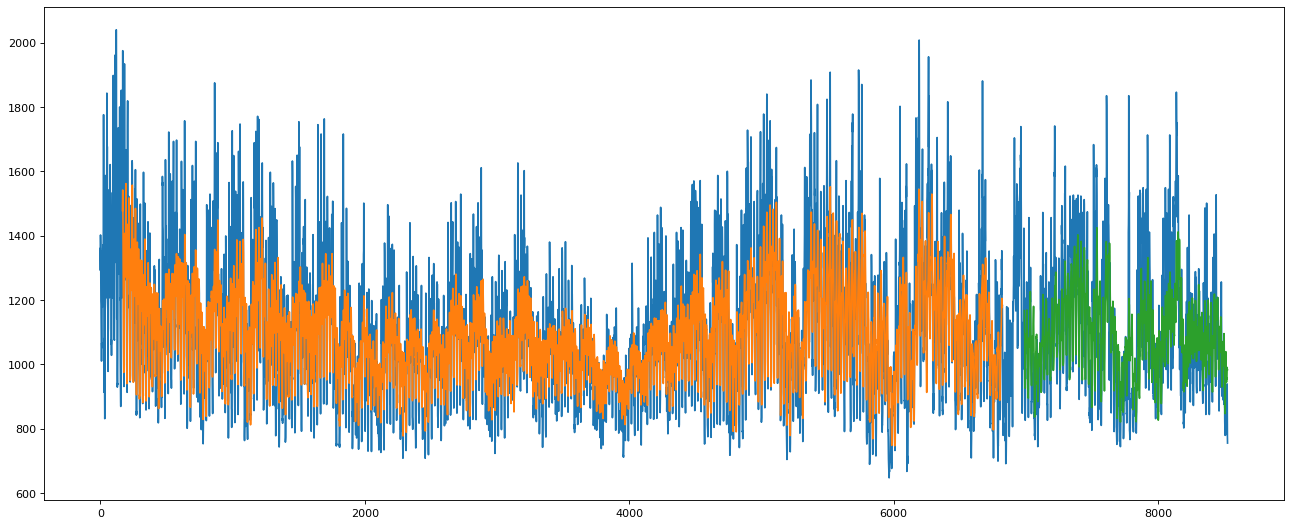

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(rescaled_pred_train)+look_back, :] = rescaled_pred_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(rescaled_pred_train)+(look_back*2)+1:len(dataset)-1, :] = rescaled_pred_test
# plot baseline and predictions
figure(figsize=(20, 8), dpi=80)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

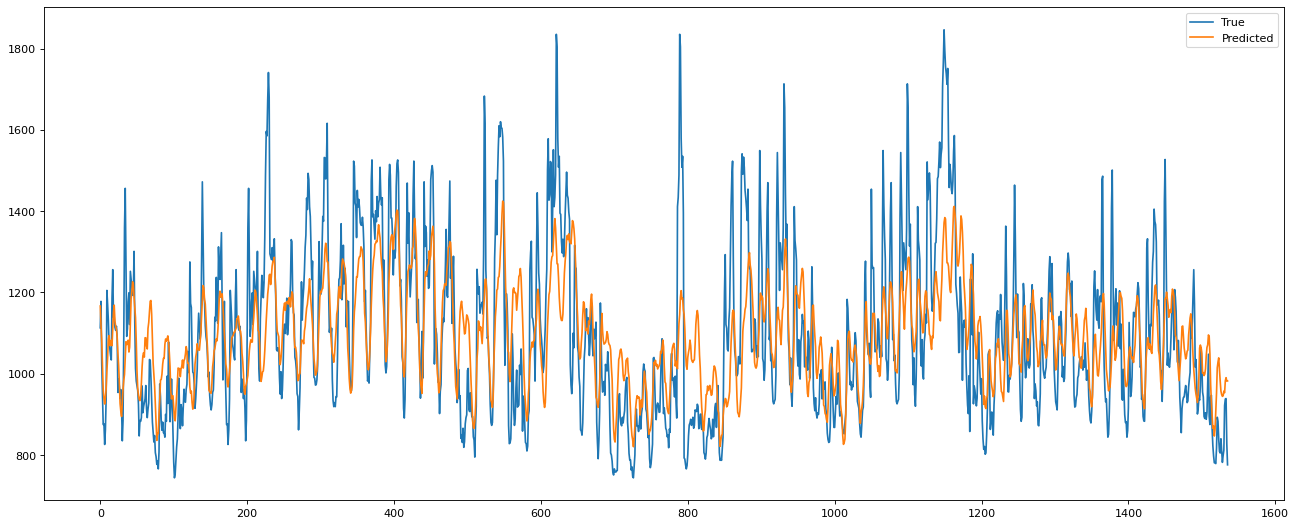

In [ ]:
#Previsti contro effettivi
figure(figsize=(20, 8), dpi=80)
plt.plot(rescaled_test_y[0], label='True')
plt.plot(rescaled_pred_test[:,0], label='Predicted')
plt.legend(loc="upper right")
plt.show()


### 1 layer LSTM 128 e dropout con 0.5, altro layer LSTM 64 e dropout 0.5 optimizer Adagrad

In [ ]:
model2=Sequential()
model2.add(LSTM(128, input_shape=(1, look_back), return_sequences=True))
model2.add(LeakyReLU())
model2.add(Dropout(0.3))
model2.add(LSTM(64, return_sequences=False))
model2.add(LeakyReLU())
model2.add(Dropout(0.2))
model2.add(Dense(1))

In [ ]:
model2.compile(loss='mean_squared_error',  # funzione di errore che dovrà essere minimizzata in fase di training
              optimizer='Adagrad')

In [ ]:
model2.fit(TrainX, TrainY, epochs=100, batch_size=32, verbose=2, callbacks = [early_stop], shuffle=False)

Epoch 1/100
208/208 - 4s - loss: 0.1054 - 4s/epoch - 19ms/step
Epoch 2/100
208/208 - 1s - loss: 0.0845 - 1s/epoch - 6ms/step
Epoch 3/100
208/208 - 1s - loss: 0.0707 - 1s/epoch - 6ms/step
Epoch 4/100
208/208 - 1s - loss: 0.0601 - 1s/epoch - 6ms/step
Epoch 5/100
208/208 - 1s - loss: 0.0515 - 1s/epoch - 6ms/step
Epoch 6/100
208/208 - 1s - loss: 0.0447 - 1s/epoch - 6ms/step
Epoch 7/100
208/208 - 1s - loss: 0.0397 - 907ms/epoch - 4ms/step
Epoch 8/100
208/208 - 1s - loss: 0.0354 - 915ms/epoch - 4ms/step
Epoch 9/100
208/208 - 1s - loss: 0.0320 - 892ms/epoch - 4ms/step
Epoch 10/100
208/208 - 1s - loss: 0.0298 - 911ms/epoch - 4ms/step
Epoch 11/100
208/208 - 1s - loss: 0.0281 - 900ms/epoch - 4ms/step
Epoch 12/100
208/208 - 1s - loss: 0.0268 - 896ms/epoch - 4ms/step
Epoch 13/100
208/208 - 1s - loss: 0.0258 - 904ms/epoch - 4ms/step
Epoch 14/100
208/208 - 1s - loss: 0.0251 - 900ms/epoch - 4ms/step
Epoch 15/100
208/208 - 1s - loss: 0.0245 - 1s/epoch - 5ms/step
Epoch 16/100
208/208 - 1s - loss: 0.024

### Previsione del test e valutazione modello

In [ ]:
#Previsioni
pred_mod2_train = model2.predict(TrainX)
pred_mod2_test = model2.predict(TestX)

48/48 [==============================] - 0s 3ms/step


In [ ]:
#Per valutare bontà di previsioni le riscalo e le confronto con i dati originali riscalati
#Train
rescaled_pred_train2 = scaler.inverse_transform(pred_mod2_train)
rescaled_train_y2 = scaler.inverse_transform([TrainY])
#Test
rescaled_pred_test2 = scaler.inverse_transform(pred_mod2_test)
rescaled_test_y2 = scaler.inverse_transform([TestY])


In [ ]:
#MAPE train
MAPE_train2=mape(rescaled_train_y2[0], rescaled_pred_train2[:,0])
MAPE_train2

0.149074431817556

In [ ]:
#MAPE test
MAPE_test2=mape(rescaled_test_y2[0], rescaled_pred_test2[:,0])
MAPE_test2

0.15063091376131563

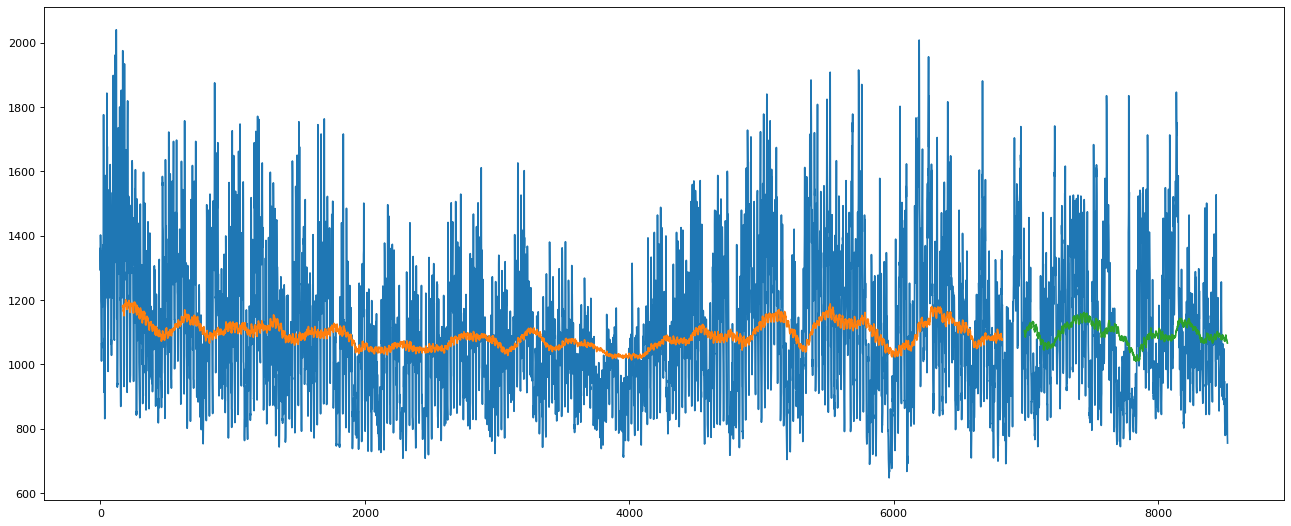

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(rescaled_pred_train2)+look_back, :] = rescaled_pred_train2
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(rescaled_pred_train2)+(look_back*2)+1:len(dataset)-1, :] = rescaled_pred_test2
# plot baseline and predictions
figure(figsize=(20, 8), dpi=80)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

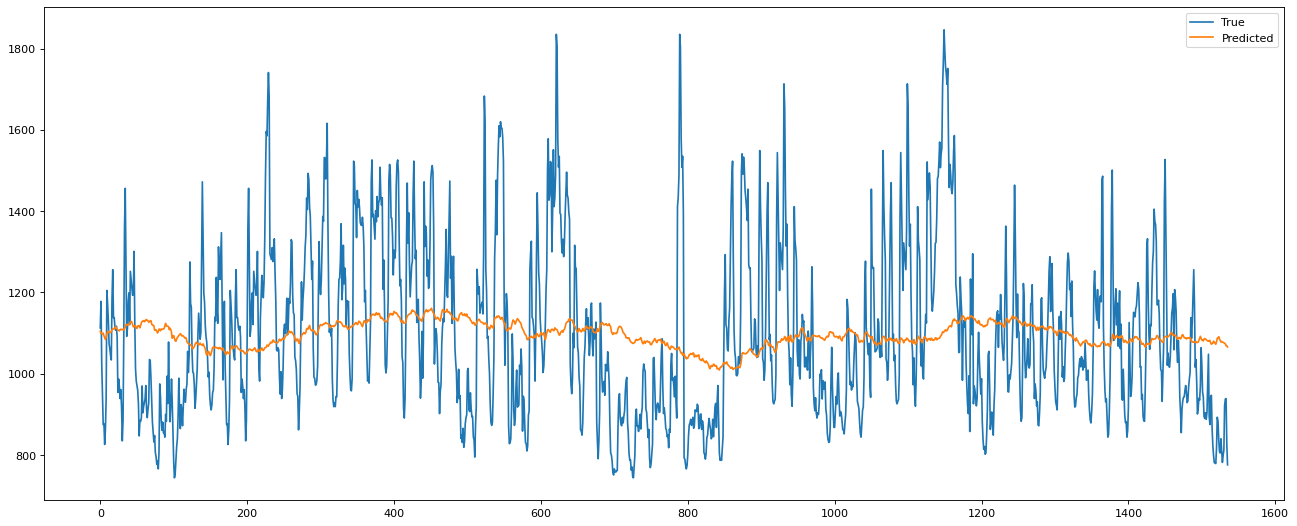

In [ ]:
#Predetti contro effettivi
figure(figsize=(20, 8), dpi=80)
plt.plot(rescaled_test_y2[0], label='True')
plt.plot(rescaled_pred_test2[:,0], label='Predicted')
plt.legend(loc="upper right")
plt.show()

# Modello GRU

## GRU

In [ ]:
# reshape into X=t and Y=t+1
#look_back = 168
Xtrain, Ytrain = X_Y_split(train, look_back)
Xtest, Ytest = X_Y_split(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))

In [ ]:
early_stop = EarlyStopping(monitor = 'loss', patience = 5)

In [ ]:
model_GRU = Sequential()
model_GRU.add(GRU(128, input_shape=(1, look_back), return_sequences=True))
model_GRU.add(Dropout(0.5))
model_GRU.add(GRU(64, return_sequences=True))
model_GRU.add(GRU(32))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(1))

In [ ]:
model_GRU.compile(loss='mean_squared_error', optimizer='Adagrad')

In [ ]:
model_GRU.fit(Xtrain, Ytrain, epochs=100, batch_size=32, verbose=1, callbacks = [early_stop])

Epoch 1/100
208/208 [==============================] - 7s 6ms/step - loss: 0.0603
Epoch 2/100
208/208 [==============================] - 1s 6ms/step - loss: 0.0317
Epoch 3/100
208/208 [==============================] - 1s 6ms/step - loss: 0.0301
Epoch 4/100
208/208 [==============================] - 1s 6ms/step - loss: 0.0294
Epoch 5/100
208/208 [==============================] - 1s 6ms/step - loss: 0.0286
Epoch 6/100
208/208 [==============================] - 2s 7ms/step - loss: 0.0275
Epoch 7/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0270
Epoch 8/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0269
Epoch 9/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0264
Epoch 10/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0257
Epoch 11/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0255
Epoch 12/100
208/208 [==============================] - 1s 7ms/step - loss: 0.0256
Epoch 13/100


### Previsioni sul test e valutazione del modello

In [ ]:
#Si fanno le previsioni
pred_train = model_GRU.predict(Xtrain)
pred_test = model_GRU.predict(Xtest)


48/48 [==============================] - 0s 3ms/step


In [ ]:
#Si riportano i dati nella forma originale  e si riscalano anche le previsioni
train_rescaled_Y3 = scaler.inverse_transform([Ytrain])
pred_train_rescaled_Y3 = scaler.inverse_transform(pred_train)

test_rescaled_Y3 = scaler.inverse_transform([Ytest])
pred_test_rescaled_Y3 = scaler.inverse_transform(pred_test)

In [ ]:
#Valutazione performance predittive
GRU_train_MAPE = mape(train_rescaled_Y3[0], pred_train_rescaled_Y3[:,0])
GRU_train_MAPE

0.09606188989179314

In [ ]:
GRU_test_MAPE = mape(test_rescaled_Y3[0], pred_test_rescaled_Y3[:, 0])
GRU_test_MAPE

0.10347771344762603

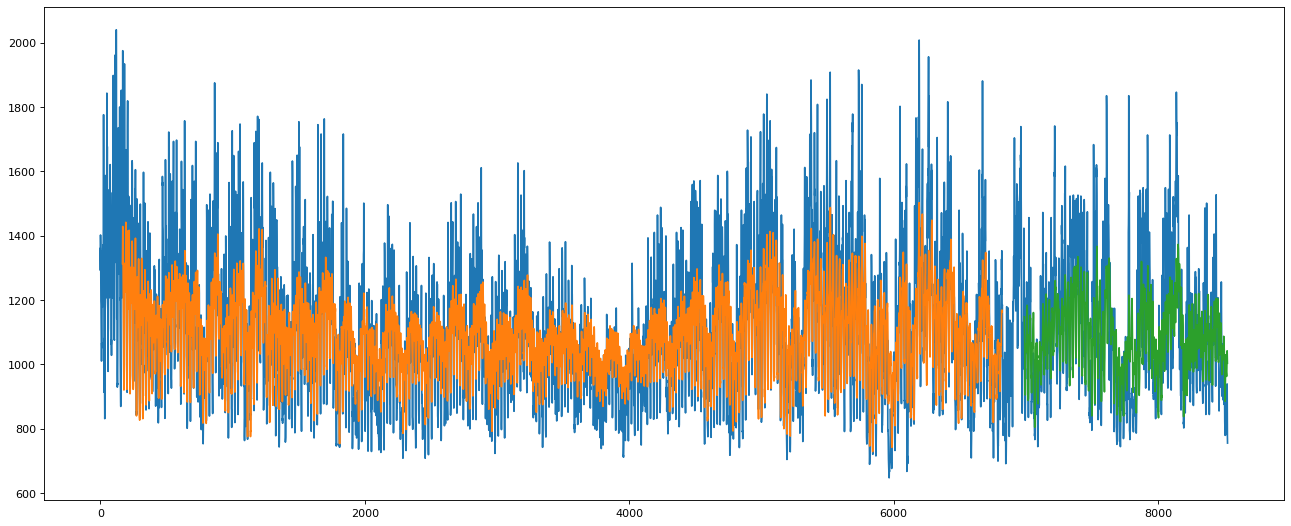

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(pred_train_rescaled_Y3)+look_back, :] = pred_train_rescaled_Y3
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(pred_train_rescaled_Y3)+(look_back*2)+1:len(dataset)-1, :] = pred_test_rescaled_Y3
# plot baseline and predictions
figure(figsize=(20, 8), dpi=80)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

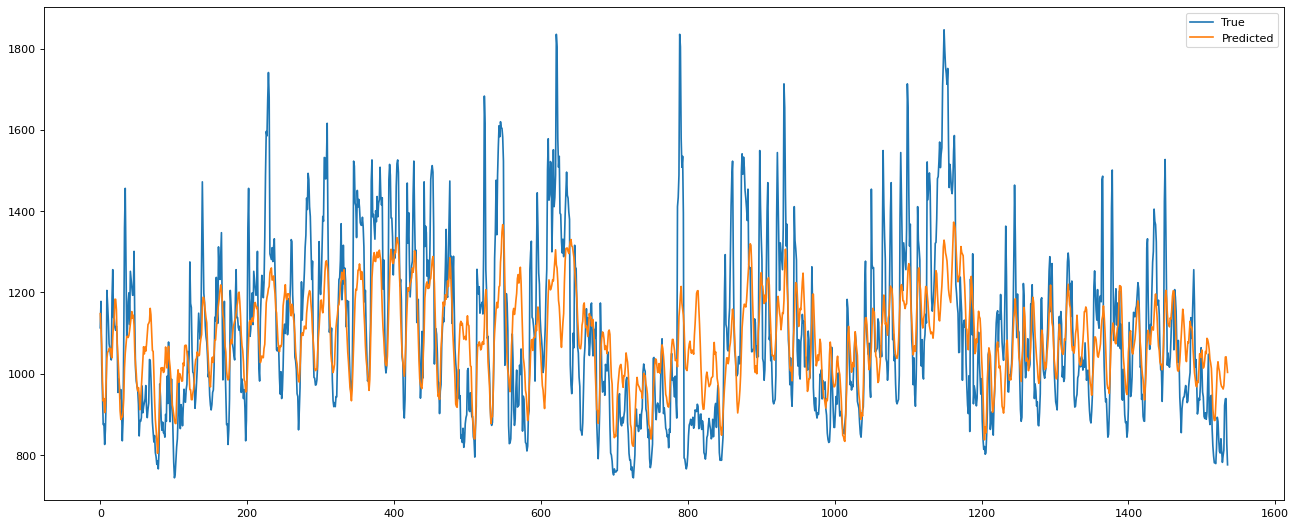

In [ ]:
#Predetti contro effettivi
figure(figsize=(20, 8), dpi=80)
plt.plot(test_rescaled_Y3[0], label='True')
plt.plot(pred_test_rescaled_Y3[:,0], label='Predicted')
plt.legend(loc="upper right")
plt.show()

## GRU 2

In [ ]:
early_stop = EarlyStopping(monitor = 'loss', patience = 5)

In [ ]:
model_GRU2 = Sequential()
model_GRU2.add(GRU(128, input_shape=(1, look_back), return_sequences=True))
model_GRU2.add(Dropout(0.5))
model_GRU2.add(GRU(64))
model_GRU2.add(Dropout(0.5))
model_GRU2.add(Dense(1))

In [ ]:
model_GRU2.compile(loss='mean_squared_error', optimizer='Adagrad')

In [ ]:
model_GRU2.fit(Xtrain, Ytrain, epochs=100, batch_size=32, verbose=1, callbacks = [early_stop])

Epoch 1/100
208/208 [==============================] - 4s 5ms/step - loss: 0.0564
Epoch 2/100
208/208 [==============================] - 1s 5ms/step - loss: 0.0388
Epoch 3/100
208/208 [==============================] - 1s 6ms/step - loss: 0.0370
Epoch 4/100
208/208 [==============================] - 1s 6ms/step - loss: 0.0340
Epoch 5/100
208/208 [==============================] - 1s 7ms/step - loss: 0.0318
Epoch 6/100
208/208 [==============================] - 1s 6ms/step - loss: 0.0300
Epoch 7/100
208/208 [==============================] - 1s 6ms/step - loss: 0.0284
Epoch 8/100
208/208 [==============================] - 1s 5ms/step - loss: 0.0270
Epoch 9/100
208/208 [==============================] - 1s 5ms/step - loss: 0.0262
Epoch 10/100
208/208 [==============================] - 1s 5ms/step - loss: 0.0256
Epoch 11/100
208/208 [==============================] - 1s 5ms/step - loss: 0.0242
Epoch 12/100
208/208 [==============================] - 1s 5ms/step - loss: 0.0237
Epoch 13/100


### Previsioni sul test e valutazione del modello

In [ ]:
#Si fanno le previsioni
pred_train_g2 = model_GRU2.predict(Xtrain)
pred_test_g2 = model_GRU2.predict(Xtest)


48/48 [==============================] - 0s 2ms/step


In [ ]:
#Si riportano i dati nella forma originale  e si riscalano anche le previsioni
train_rescaled_Y4 = scaler.inverse_transform([Ytrain])
pred_train_rescaled_Y4 = scaler.inverse_transform(pred_train_g2)

test_rescaled_Y4 = scaler.inverse_transform([Ytest])
pred_test_rescaled_Y4 = scaler.inverse_transform(pred_test_g2)

In [ ]:
#Valutazione performance predittive
GRU2_train_MAPE = mape(train_rescaled_Y4[0], pred_train_rescaled_Y4[:,0])
GRU2_train_MAPE

0.08630658968698278

In [ ]:
GRU2_test_MAPE = mape(test_rescaled_Y4[0], pred_test_rescaled_Y4[:, 0])
GRU2_test_MAPE

0.09228457176805842

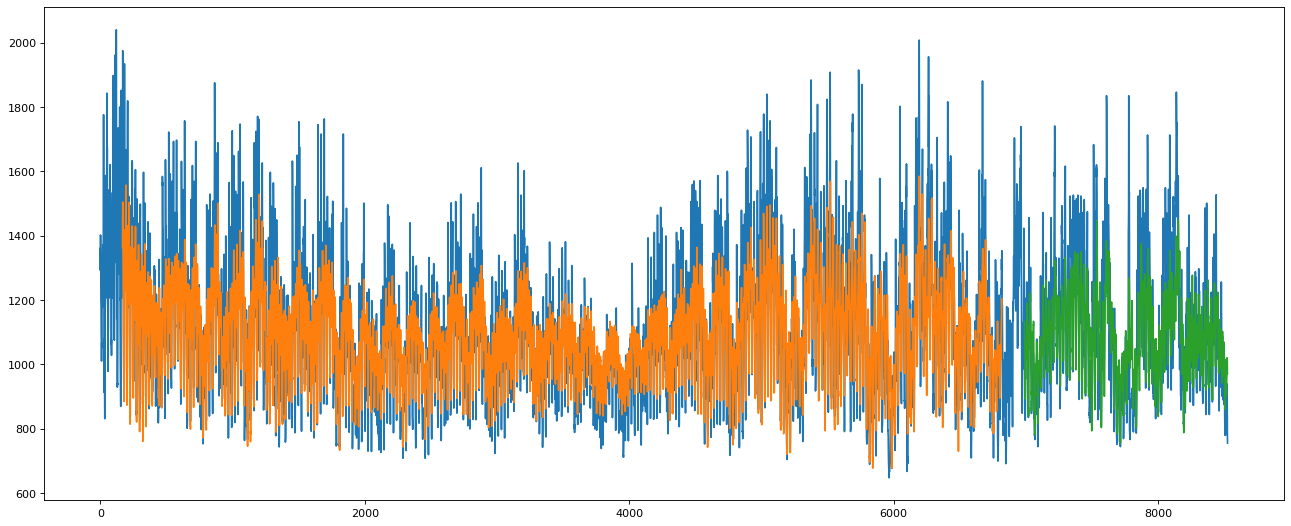

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(pred_train_rescaled_Y4)+look_back, :] = pred_train_rescaled_Y4
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(pred_train_rescaled_Y4)+(look_back*2)+1:len(dataset)-1, :] = pred_test_rescaled_Y4
# plot baseline and predictions
figure(figsize=(20, 8), dpi=80)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

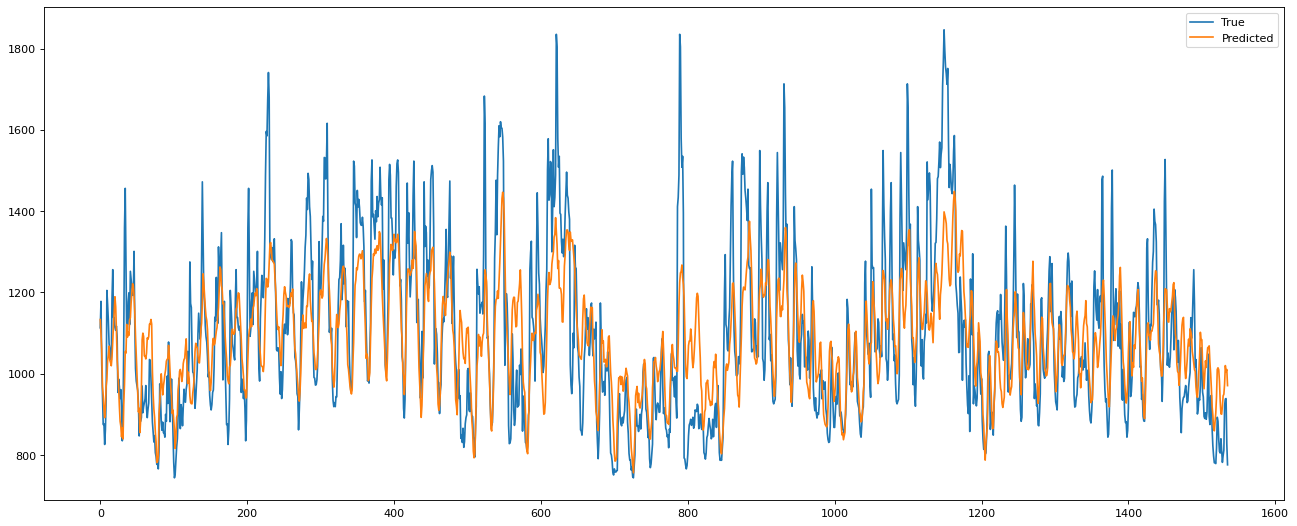

In [ ]:
#Predetti contro effettivi
figure(figsize=(20, 8), dpi=80)
plt.plot(test_rescaled_Y4[0], label='True')
plt.plot(pred_test_rescaled_Y4[:,0], label='Predicted')
plt.legend(loc="upper right")
plt.show()

# Confronto tra i modelli

In [ ]:
MAPE_dict = {"LSTM1":round(MAPE_test, 4), "LSTM2":round(MAPE_test2, 4), "GRU1":round(GRU_test_MAPE, 4), "GRU2":round(GRU2_test_MAPE,4)}
models = list(MAPE_dict.keys())
performance = list(MAPE_dict.values())

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha="center",
                 Bbox = dict(facecolor = 'white', alpha =.8))

AttributeError: ignored

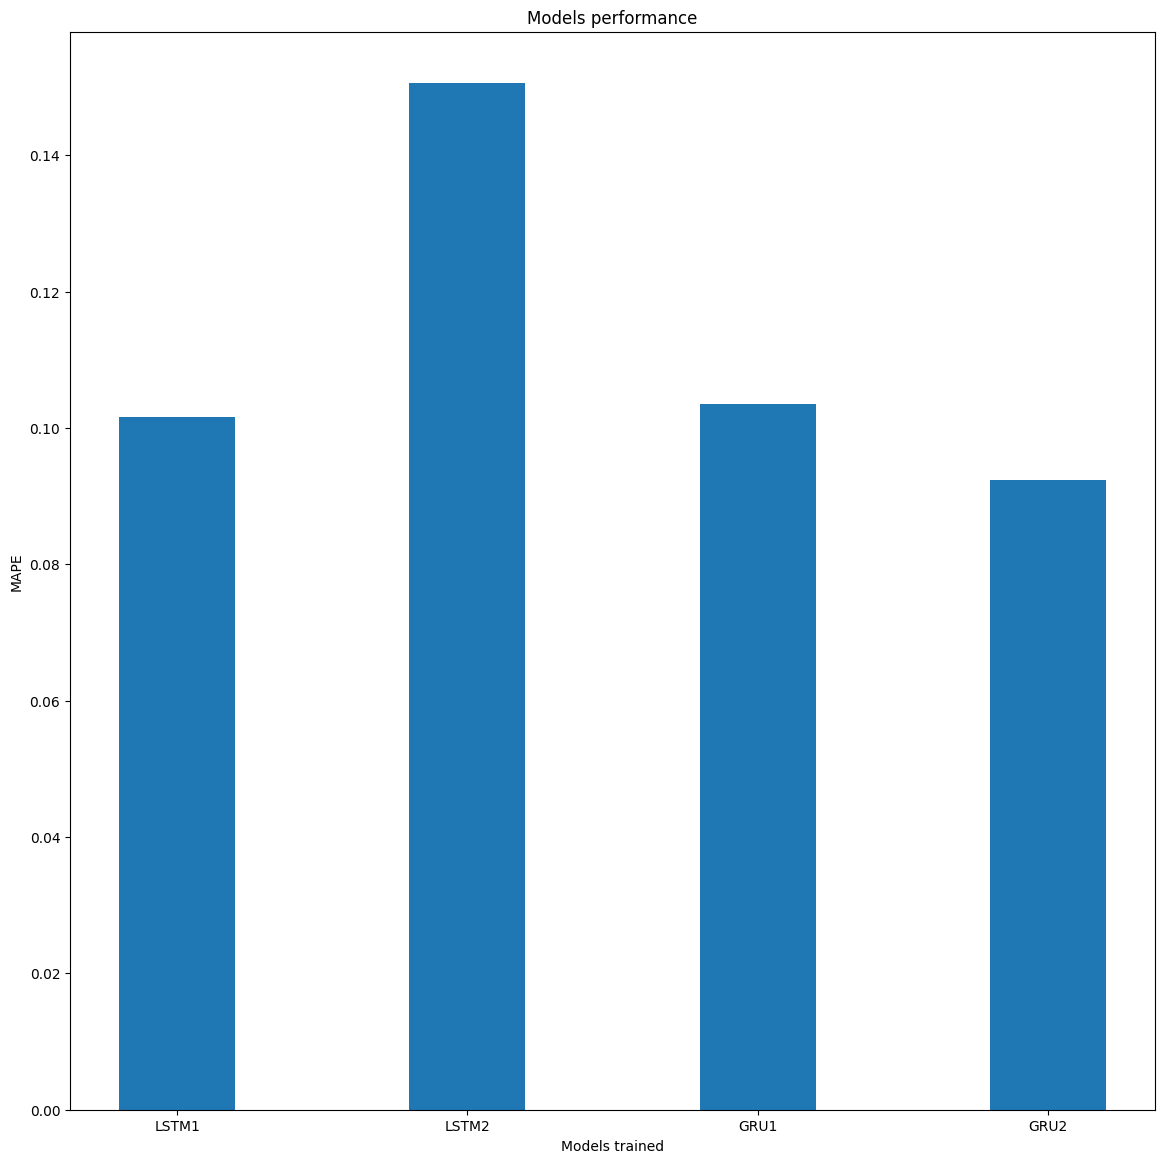

In [ ]:
fig = plt.figure(figsize=(14, 14))
plt.bar(models, performance, width=0.4)
plt.xlabel("Models trained")
plt.ylabel("MAPE")
plt.title("Models performance")
addlabels(models, performance)
plt.show()